# (d)Transfer Learning



In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DSMLProjectNew/data.zip

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory

data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [5]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [31]:
!pip install tensorflow
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        # img = img / 255.0


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size,  drop_remainder=True)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [32]:
print("Size of train data - ", len(tf_dataset_train))
print("Size of train data - ", len(tf_dataset_val))
print("Size of train data - ", len(tf_dataset_test))

Size of train data -  927
Size of train data -  352
Size of train data -  400


In [ ]:
# Printing the tensors in the training dataset - First batch
print(np.shape(tf_dataset_train))
for img, label in tf_dataset_train.take(1):
    print("Tensors in train data")
    print("Image Tensor1:")
    print(img.numpy())  # Converting the image tensor to NumPy array
    print("\nLabel Tensor1:")
    print(label.numpy())  # Convert the label tensor to NumPy array

# Printing the tensors in the validation dataset - First batch
for img, label in tf_dataset_val.take(1):
    print("Tensors in val data")
    print("Image Tensor2:")
    print(img.numpy())
    print("\nLabel Tensor2:")
    print(label.numpy())

# Printing the tensors in the test dataset - First batch
for img, label in tf_dataset_test.take(1):
    print("Tensors in test data")
    print("Image Tensor3:")
    print(img.numpy())
    print("\nLabel Tensor3:")
    print(label.numpy())


In [33]:
import cv2
import numpy as np
import os

def augment_data(image, label):
    # Applying transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)


    # Cropping and resizing back to original size
    image = tf.image.random_crop(image, size=[32, *IMAGE_SIZE, 3])
    image = tf.image.resize(image, (299,299))


    # Random translation
    image = tf.image.pad_to_bounding_box(image, offset_height=20, offset_width=20, target_height=IMAGE_SIZE[0] + 40, target_width=IMAGE_SIZE[1] + 40)

    # Random zoom
    scale = tf.random.uniform([], 0.8, 1.2)
    h, w = IMAGE_SIZE[0], IMAGE_SIZE[1]
    new_height, new_width = h * scale, w * scale
    image = tf.image.resize(image, [int(new_height), int(new_width)])
    image = tf.image.resize_with_crop_or_pad(image, h, w)

    return image, label


def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=2)  # Assuming 2 classes
    return image, label


# Apply augmentation to each image in the dataset
tf_dataset_train_augmented = tf_dataset_train.map(augment_data)

tf_data_train_one_hot_encoded = tf_dataset_train.map(one_hot_encode)
tf_data_train_augmeted_one_hot_encoded = tf_dataset_train_augmented.map(one_hot_encode)
tf_data_test_one_hot_encoded = tf_dataset_test.map(one_hot_encode)
tf_data_val_one_hot_encoded = tf_dataset_val.map(one_hot_encode)

# Concatenating the datasets one after the other and shuffling
tf_data_combined_one_hot_encoded = tf.data.Dataset.concatenate(tf_data_train_one_hot_encoded, tf_data_train_augmeted_one_hot_encoded)

tf_data_combined_one_hot_encoded_shuffled = tf_data_combined_one_hot_encoded.shuffle(buffer_size=64)
# Take one batch for demonstration
for img, label in tf_data_train_augmeted_one_hot_encoded.take(1):
    # Convert the image and label tensors to NumPy arrays and print
    image_array = img.numpy()
    label_array = label.numpy()

    # Print the image tensor
    print("Augmented Image Tensor:")
    print(image_array)

    # Print the label tensor
    print("\nAugmented Label Tensor:")
    print(label_array)
len(tf_data_combined_one_hot_encoded)


Augmented Image Tensor:
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
  

1854

In [34]:
y_test_list = []


for _, label in tf_data_test_one_hot_encoded:
    for a in label.numpy():
        y_test_list.append(a)
y_test = np.argmax(y_test_list, axis=1)

In [35]:
print(len(y_test))

12800


In [36]:
unbatched_tf_data_combined_one_hot_encoded = tf_data_combined_one_hot_encoded.unbatch()
batched_tf_data_combined_one_hot_encoded = unbatched_tf_data_combined_one_hot_encoded.batch(8)


unbatched_tf_data_train_augmeted_one_hot_encoded = tf_data_train_augmeted_one_hot_encoded .unbatch()
batched_tf_data_train_augmeted_one_hot_encoded  = unbatched_tf_data_train_augmeted_one_hot_encoded.batch(8)


unbatched_tf_data_val_one_hot_encoded = tf_data_val_one_hot_encoded.unbatch()
batched_tf_data_val_one_hot_encoded = unbatched_tf_data_val_one_hot_encoded.batch(8)

unbatched_tf_data_test_one_hot_encoded = tf_data_test_one_hot_encoded.unbatch()
batched_tf_data_test_one_hot_encoded = unbatched_tf_data_test_one_hot_encoded.batch(8)


In [16]:
SEED = 19
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Define common model configurations
BATCH_SIZE = 8
EPOCHS = 11

SEED = 19
np.random.seed(SEED)
tf.random.set_seed(SEED)

def create_transfer_model(base_model):
    # Instantiate the base model
    base_model_instance = base_model(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze all layers in the base model
    for layer in base_model_instance.layers:
        layer.trainable = False

    # Create a new model on top
    model = models.Sequential([
        base_model_instance,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')  # Set num_classes based on your dataset
    ])

    return model

# Compile models
def compile_model(model, learning_rate=0.001):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Compile transfer learning models
efficientnet_transfer_model = compile_model(create_transfer_model(EfficientNetB0))
resnet_transfer_model = compile_model(create_transfer_model(ResNet50))
vgg16_transfer_model = compile_model(create_transfer_model(VGG16))

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model_checkpoint1 = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_1.h5', monitor='val_loss', save_best_only=True, mode='min')
model_checkpoint2 = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_2.h5', monitor='val_loss', save_best_only=True, mode='min')
model_checkpoint3 = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_3.h5', monitor='val_loss', save_best_only=True, mode='min')

In [17]:
# Plot training and validation errors vs. epochs
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 6))

    # Calculate errors (1 - accuracy)
    train_errors = 1 - np.array(history.history['accuracy'])
    val_errors = 1 - np.array(history.history['val_accuracy'])

    # Plot training and validation errors
    plt.subplot(1, 2, 1)
    plt.plot(train_errors, label='Train Error')
    plt.plot(val_errors, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'{model_name} Training and Validation Error')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Train transfer learning models
run_eagerly = True
efficientnet_history = efficientnet_transfer_model.fit(
    batched_tf_data_combined_one_hot_encoded,
    epochs=EPOCHS,
    validation_data=batched_tf_data_val_one_hot_encoded,
    callbacks=[early_stopping, model_checkpoint1]
)

EfficientNetB0


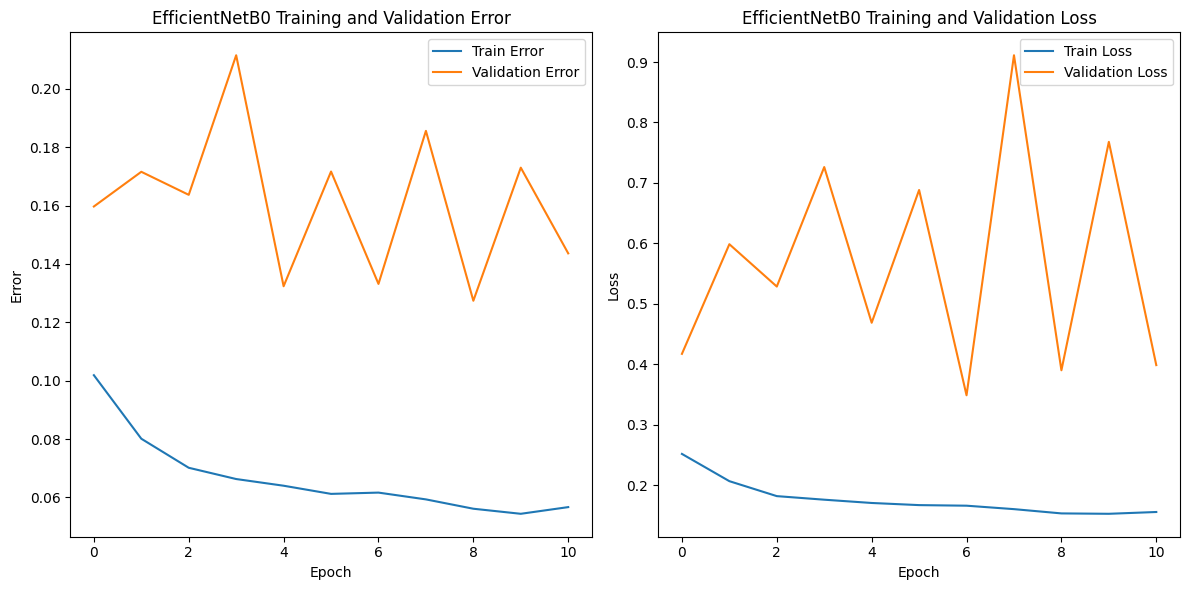

In [19]:
print("EfficientNetB0")
plot_training_history(efficientnet_history, 'EfficientNetB0')

plotting training and validation accuracy


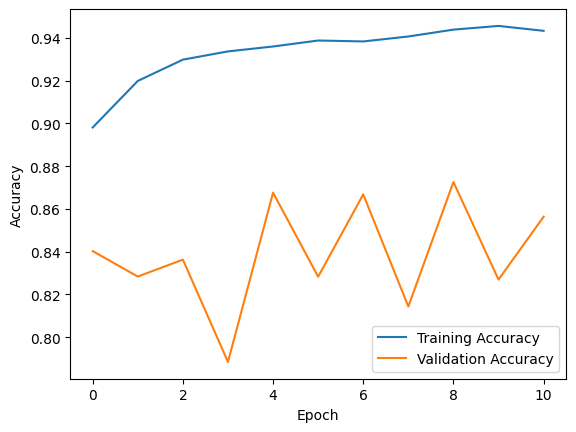

In [22]:
# Plot training and validation accuracy
print("plotting training and validation accuracy")
plt.plot(efficientnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(efficientnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions
y_pred = efficientnet_transfer_model.predict(batched_tf_data_test_one_hot_encoded)

1600/1600 [==============================] - 54s 34ms/step


In [38]:
y_pred = np.argmax(y_pred, axis=1)

In [39]:
# Classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4410
           1       0.95      0.98      0.97      8390

    accuracy                           0.95     12800
   macro avg       0.96      0.94      0.95     12800
weighted avg       0.95      0.95      0.95     12800



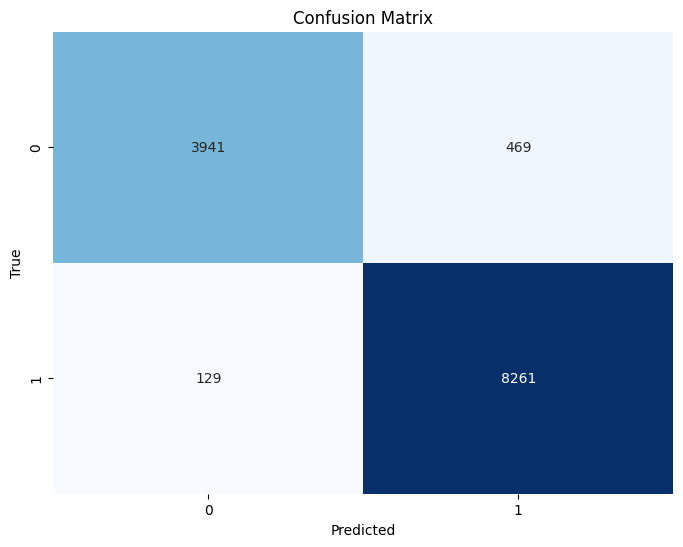

In [40]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
resnet_history = resnet_transfer_model.fit(
    batched_tf_data_combined_one_hot_encoded,
    epochs=EPOCHS,
    validation_data=batched_tf_data_val_one_hot_encoded,
    callbacks=[early_stopping, model_checkpoint2]
)

Epoch 1/11
7416/7416 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7416/7416 [==============================] - 524s 70ms/step - loss: 0.1797 - accuracy: 0.9323 - val_loss: 1.1661 - val_accuracy: 0.6318
Epoch 2/11
7416/7416 [==============================] - 510s 69ms/step - loss: 0.1374 - accuracy: 0.9498 - val_loss: 1.5518 - val_accuracy: 0.5693
Epoch 3/11
7416/7416 [==============================] - 511s 69ms/step - loss: 0.1221 - accuracy: 0.9556 - val_loss: 1.0414 - val_accuracy: 0.6839
Epoch 4/11
7416/7416 [==============================] - 513s 69ms/step - loss: 0.1106 - accuracy: 0.9603 - val_loss: 0.5892 - val_accuracy: 0.8002
Epoch 5/11
7416/7416 [==============================] - 506s 68ms/step - loss: 0.1041 - accuracy: 0.9642 - val_loss: 0.9491 - val_accuracy: 0.7447
Epoch 6/11
7416/7416 [==============================] - 497s 67ms/step - loss: 0.1001 - accuracy: 0.9658 - val_loss: 0.6222 - val_accuracy: 0.8250
Epoch 7/11
7416/7416 [==============================] - 523s 71ms/step - loss: 0.1032 - accuracy: 0.9651 - val_loss: 0.5674 - val

In [28]:
resnet_transfer_model.save_weights('/content/drive/MyDrive/best_model_resnet.h5')

ResNet50


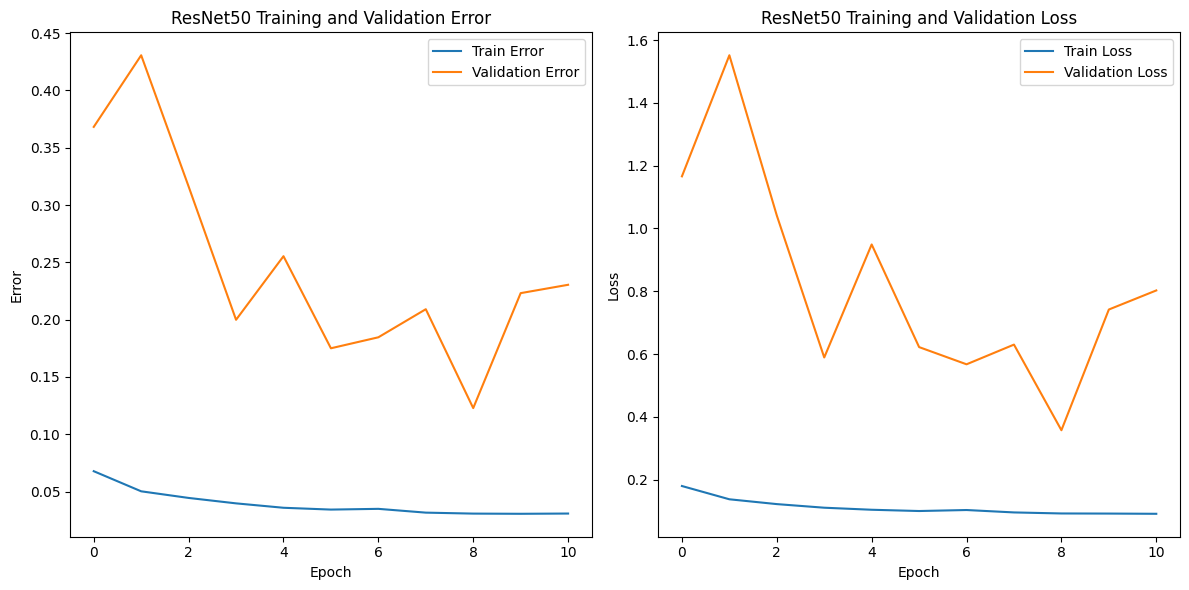

In [44]:
print("ResNet50")
plot_training_history(resnet_history, 'ResNet50')

plotting training and validation accuracy


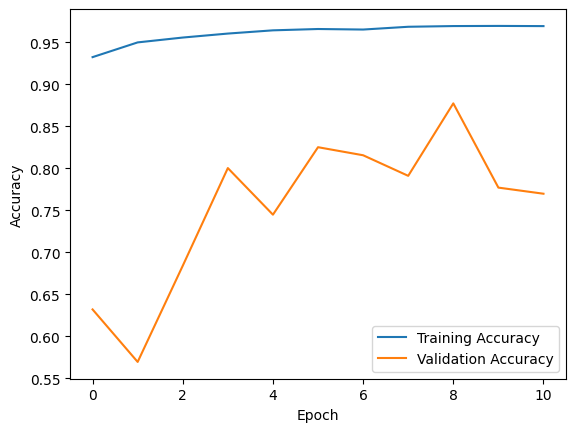

In [45]:
#Plot training and validation accuracy
print("plotting training and validation accuracy")
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# Make predictions for ResNet model
y_pred = resnet_transfer_model.predict(batched_tf_data_test_one_hot_encoded)
y_pred = np.argmax(y_pred, axis=1)

1600/1600 [==============================] - 62s 38ms/step


In [43]:
# Classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4410
           1       0.93      0.99      0.96      8390

    accuracy                           0.95     12800
   macro avg       0.96      0.92      0.94     12800
weighted avg       0.95      0.95      0.94     12800



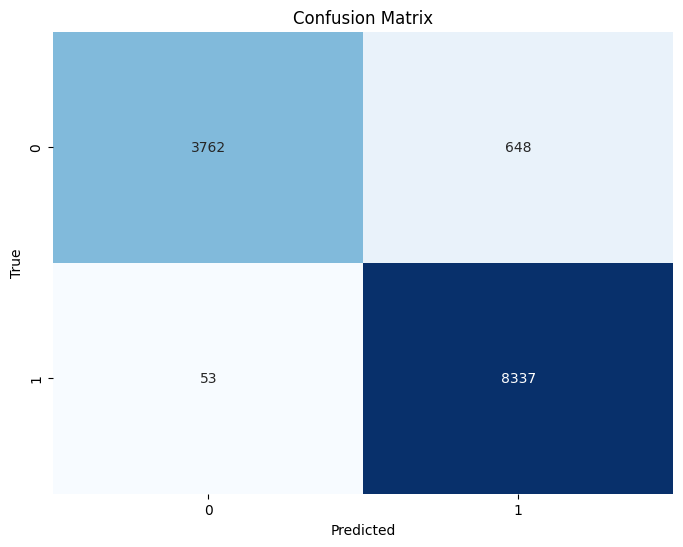

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Comparing the results of transfer learning with those of CNN + MLP

**Comparing results:**

The accuracy on the test data:



*   CNN + MLP - 84%
*   EfficientNetB0 - 95%
*   ResNet50 - 95%








**Inference:**

*   The transfer learning models took comparitively lesser time to train than CNN+MLP - each model took only about 1/4th of the time taken by the CNN+MLP model used
* Transfer lerning leverages pretrained models and  benefits from training on a more extensive dataset, allowing for effective fine-tuning to address our specific problem.
*   The higher accuracy indicates that the EfficientNetB0, ResNet50 and VGG16 models which have leveraging transfer learning from a pre-trained model, effectively adapted its knowledge to the specific task at hand. It capitalized on the pre-trained features and representations, leading to better generalization and improved accuracy on the test data.





